## Qualtative analysis

The purpose of this notebook is to analyse the user perception of our system's deliverables, in particular the LLM-generated report's effectivenes at making XAI methods easier to comprehend. 

**About the survey**

The survey engine randomly selected a sample (one of three) for each participant. The samples we had prepared for the research included cases with borderline, malignant, and benign predictions. Explanation A (with XAI methods' outputs) and Explanation B (the same XAI methods + LLM-generated report)  were used to assess the ease of understanding. In addition, questions referring to the actionability and trustworthiness of those explanations were presented to participants with clinical background. At the end of the survey, a free-text box was provided for additional feedback on the system (not included in the dataset for data protection reasons).


### Libraries

In [1]:
from pathlib import Path
import re
import warnings
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warning about openpyxl (the survey_data.xls does not have a default style)
warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')

### Constants

In [2]:
root_dir = Path.cwd().parent
data_dir = root_dir / "results"
dataset_dir = data_dir / "survey_data.xlsx"

### Tools

In [3]:
def load_survey_data(file_path):
    """
    Load survey data using only the first row as column names.
    
    Parameters:
    file_path (str): Path to the Excel file
    
    Returns:
    pd.DataFrame: DataFrame with first row as column headers
    """
    
    # Read the Excel file
    df = pd.read_excel(file_path, header=[0], skiprows=[1])
    
    return df

In [4]:
def process_survey_columns(df):
    """
    Process survey data where each participant saw only one sample and answered questions about it.
    
    This function consolidates data collected in respect of 3 samples into single Q5a, Q6a, Q7a, Q5b, Q6b, Q7b columns
    and adds a 'sample' column indicating which sample the participant saw.
    
    Arguments:
    df (pd.DataFrame): original survey dataset
    
    Returns:
    Processed pd.DataFrame with consolidated columns
    """
    
    # Define the questions to consolidate survey data
    questions = ['Q5a', 'Q6a', 'Q7a', 'Q5b', 'Q6b', 'Q7b']
    
    # Define other columns 
    other_columns = ['Q1', 'Q2', 'Q3', 'Consent', 'RecordedDate', 'Status', 'Finished']

    
    # Create the processed dataframe starting with other columns
    processed_df = df[other_columns].copy()
    
    # Add sample and question columns (starting with None values)
    processed_df['sample'] = None
    for question in questions:
        processed_df[question] = None
    
    # Process each row
    for idx, row in df.iterrows():
        # Find which sample was seen by this participant
        participant_sample = None
        
        # Check each sample to see which one has data
        for sample_num in [1, 2, 3]:
            sample_prefix = f'S{sample_num}_'
            # Check if any question for this sample has a non-null response
            has_response = False
            for question in questions:
                sample_col = sample_prefix + question
                if sample_col in df.columns and pd.notna(row[sample_col]) and row[sample_col] != '':
                    has_response = True
                    break
            
            # If participant sample was found, break out of the loop
            if has_response:
                participant_sample = sample_num
                break
        
        # Extract the data regarding the sample
        if participant_sample is not None:
            processed_df.loc[idx, 'sample'] = participant_sample
            sample_prefix = f'S{participant_sample}_'
            
            # Extract responses for this sample
            for question in questions:
                sample_col = sample_prefix + question
                processed_df.loc[idx, question] = row[sample_col]
    
    # Reorder columns: sample + question columns + other columns
    final_columns = ['sample'] + questions + other_columns
    processed_df = processed_df[final_columns]
    
    return processed_df

In [5]:
def print_statistics(scores_a, scores_b, stats_header="Statistics"):
    """
    Print statistics for the scored answers in Explanation A and Explanation B.

    The statistics include:
    - Mean score for answers in Explanation A
    - Mean score for answers in Explanation B
    - Mean difference for the scores (Explanation B - Explanation A)
    - Statistic and p-value resulting from Wilcoxon Signed-Rank Test
    - A statement confirming if difference between scores is statistically significant

    Arguments:
    scores_a (pd.Series): ranked (scored) answers for Explanation A
    scores_b (pd.Series): ranked (scored) answers for Explanation B
    stats_header (str): expected header for the printout     
    """

    # Perform statistical test
    statistic, p_value = stats.wilcoxon(scores_a, scores_b)

    # Additional statistics ('all' stands for 'all backgrounds')
    scores_a_mean = np.mean(scores_a)
    scores_b_mean = np.mean(scores_b)
    scores_mean_diff = np.mean(scores_b - scores_a)

    print(f"***{stats_header}***")
    print(f"\nExplanation A - Mean Score: {scores_a_mean:.2f}")
    print(f"Explanation B - Mean Score: {scores_b_mean:.2f}")
    print(f"Mean Scores' Difference (Explanation B - Explanation A): {scores_mean_diff:.2f}")


    print(f"\nWilcoxon signed-rank test results:")
    print(f"Statistic: {statistic}")
    print(f"p-value: {p_value}")

    if p_value < 0.05:
        print("\nThe difference is statistically significant.")
    else:
        print("\nThe difference is not statistically significant.")

### Loading and preprocessing of the data

In [6]:
# Load the dataset
df = load_survey_data(dataset_dir)
    
# Process the dataset
processed_df = process_survey_columns(df)

In [7]:
print(f"Processed dataset shape: {processed_df.shape[0]} rows amd {processed_df.shape[1]} columns.")
processed_df.sample(5)

Processed dataset shape: 110 rows amd 14 columns.


,sample,Q5a,Q6a,Q7a,Q5b,Q6b,Q7b,Q1,Q2,Q3,Consent,RecordedDate,Status,Finished
62,3,Neither easy nor difficult to understand,NaN,NaN,Somewhat easy to understand,NaN,NaN,Non-clinical,Moderately familiar,Not familiar at all,"Yes, I agree to participate and consent to my ...",2025-08-07 04:52:12.106,IP Address,True
50,3,Very difficult to understand,NaN,NaN,Somewhat difficult to understand,NaN,NaN,Non-clinical,Moderately familiar,Not familiar at all,"Yes, I agree to participate and consent to my ...",2025-08-06 01:33:47.693,IP Address,True
97,None,None,None,None,None,None,None,Non-clinical,Slightly familiar,Not familiar at all,"Yes, I agree to participate and consent to my ...",2025-08-15 15:55:03.577,IP Address,False
54,1,Somewhat difficult to understand,NaN,NaN,Somewhat easy to understand,NaN,NaN,Non-clinical,Moderately familiar,Not familiar at all,"Yes, I agree to participate and consent to my ...",2025-08-06 06:28:45.485,IP Address,True
95,None,None,None,None,None,None,None,Non-clinical,Moderately familiar,Not familiar at all,"Yes, I agree to participate and consent to my ...",2025-08-14 09:44:07.376,IP Address,False


In [8]:
# Filter out previews (from the survey setup), unfinished surveys and surveys with lack of consent for data processing
responses = processed_df[(processed_df['Status'] == 'IP Address') & (processed_df['Finished'] == True) & (processed_df['Consent'] == 'Yes, I agree to participate and consent to my data being used for this research')]
print(f"Number of eligible surveys: {responses.shape[0]}")

# responses.head()

Number of eligible surveys: 78


### Data exploration

First we check distribution of different sample types in the survey data.

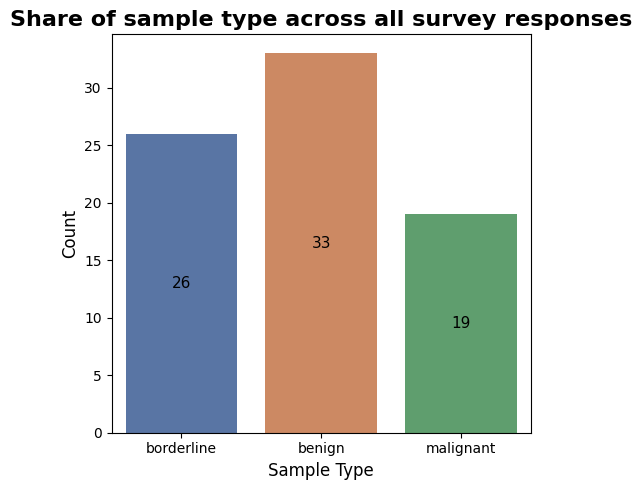

In [9]:
# Create mapping dictionary for the samples
sample_mapping = {1: 'borderline', 2: 'malignant', 3: 'benign'}

# Create a new column with mapped values
responses = responses.copy()
responses['sample_type'] = responses['sample'].map(sample_mapping)

# Plot the data
fig = plt.figure(figsize=(5, 5))
ax = sns.countplot(data=responses, x="sample_type", palette="deep", hue="sample_type", legend=False)
plt.title('Share of sample type across all survey responses', fontsize=16, fontweight='bold')
plt.xlabel('Sample Type', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Add count labels in the middle of bars
for container in ax.containers:
    # Get the bars heights, widths and positions
    for bar in container:
        height = bar.get_height()
        width = bar.get_width()
        x_pos = bar.get_x()
        # Place the counts at the centre of each bar
        ax.text(x_pos + width/2., height/2, f'{int(height)}', ha='center', va='center', fontsize=11)

plt.tight_layout()
plt.show()

The plot above reveals imbalances in the count of finished surveys for all three samples (borderline, benign and malignant) which may affect accuracy of analysis when looking into responses related to specific samples. However, for the majority of this analysis we look at combined answers for all samples.

Next, we check the share of responses from participants with clinical and non-clinical backgrounds. As we can see below, a smaller percentage of  responses was recorded from participants who selected 'Clinical' in Q1.

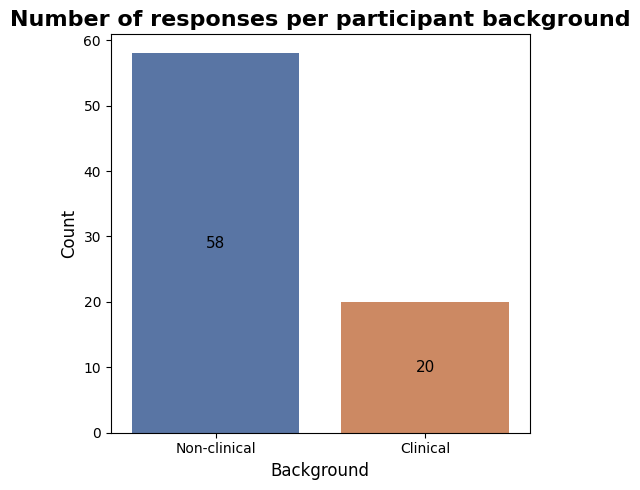

Percentage of responses from participants with clinical background: 25.6%


In [10]:
# Plot the data
plt.figure(figsize=(5, 5))
ax = sns.countplot(data=responses, x="Q1", palette="deep", hue="Q1", legend=False)
plt.title('Number of responses per participant background', fontsize=16, fontweight='bold')
plt.xlabel('Background', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Add count labels in the middle of bars
for container in ax.containers:
    # Get the bars heights, widths and positions
    for bar in container:
        height = bar.get_height()
        width = bar.get_width()
        x_pos = bar.get_x()
        # Place the counts at the centre of each bar
        ax.text(x_pos + width/2., height/2, f'{int(height)}', ha='center', va='center', fontsize=11)

plt.tight_layout()
plt.show()

# Filter based on participant background
responses_clinical = responses[responses['Q1'] == "Clinical"]
responses_nonclinical = responses[responses['Q1'] == "Non-clinical"]

print(f"Percentage of responses from participants with clinical background: {round(responses_clinical.shape[0]/len(responses) * 100,1)}%")

Next, we explore the answers relating to Q2 ("How familiar are you with using AI or machine learning models?") and Q3 ("How familiar are you with Explainable AI methods (XAI)?")

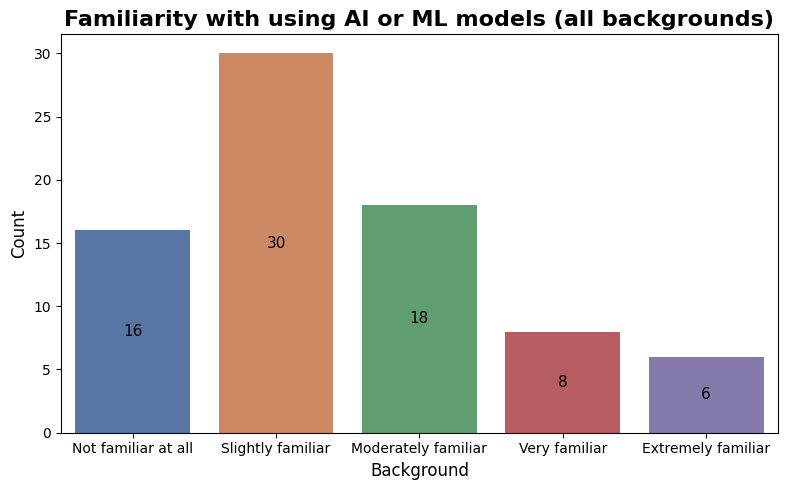

38.5% of responses came from participants with a slight familiarity with AI/ML models.


In [11]:
# Define the order for the categories
order = ['Not familiar at all', 'Slightly familiar', 'Moderately familiar', 'Very familiar', 'Extremely familiar']
hue_order = ['Not familiar at all', 'Slightly familiar', 'Moderately familiar', 'Very familiar', 'Extremely familiar']

# Plot the data
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=responses, x="Q2", palette="deep", hue="Q2", legend=False, order=order, hue_order=hue_order)
plt.title('Familiarity with using AI or ML models (all backgrounds)', fontsize=16, fontweight='bold')
plt.xlabel('Background', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Add count labels in the middle of bars
for container in ax.containers:
    # Get the bars heights, widths and positions
    for bar in container:
        height = bar.get_height()
        width = bar.get_width()
        x_pos = bar.get_x()
        # Place the counts at the centre of each bar
        ax.text(x_pos + width/2., height/2, f'{int(height)}', ha='center', va='center', fontsize=11)

plt.tight_layout()
plt.show()

print(f"{round(responses[responses['Q2'] == 'Slightly familiar'].shape[0]/len(responses) * 100,1)}% of responses came from participants with a slight familiarity with AI/ML models.")

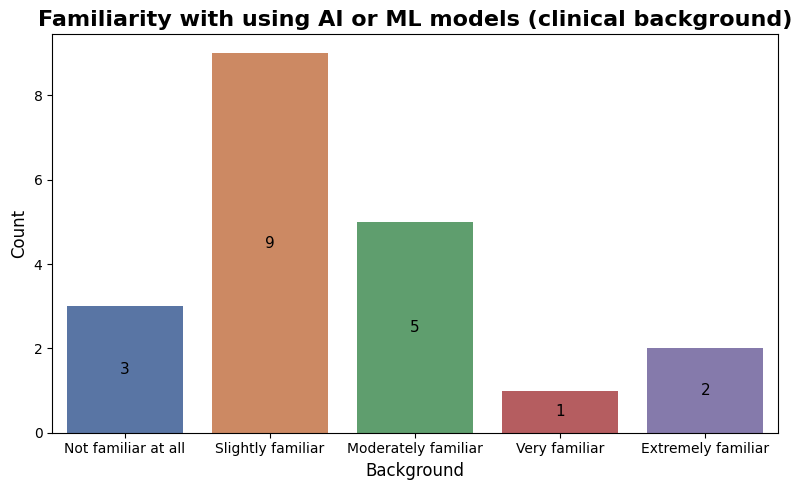

45.0% of responses from participants with clinical background pointed to a slight familiarity with AI/ML models.


In [12]:
# Plot the same question but for clinical background
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=responses_clinical, x="Q2", palette="deep", hue="Q2", legend=False, order=order, hue_order=hue_order)
plt.title('Familiarity with using AI or ML models (clinical background)', fontsize=16, fontweight='bold')
plt.xlabel('Background', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Add count labels in the middle of bars
for container in ax.containers:
    # Get the bars heights, widths and positions
    for bar in container:
        height = bar.get_height()
        width = bar.get_width()
        x_pos = bar.get_x()
        # Place the counts at the centre of each bar
        ax.text(x_pos + width/2., height/2, f'{int(height)}', ha='center', va='center', fontsize=11)

plt.tight_layout()
plt.show()

print(f"{round(responses_clinical[responses_clinical['Q2'] == 'Slightly familiar'].shape[0]/len(responses_clinical) * 100, 1)}% of responses from participants with clinical background pointed to a slight familiarity with AI/ML models.")

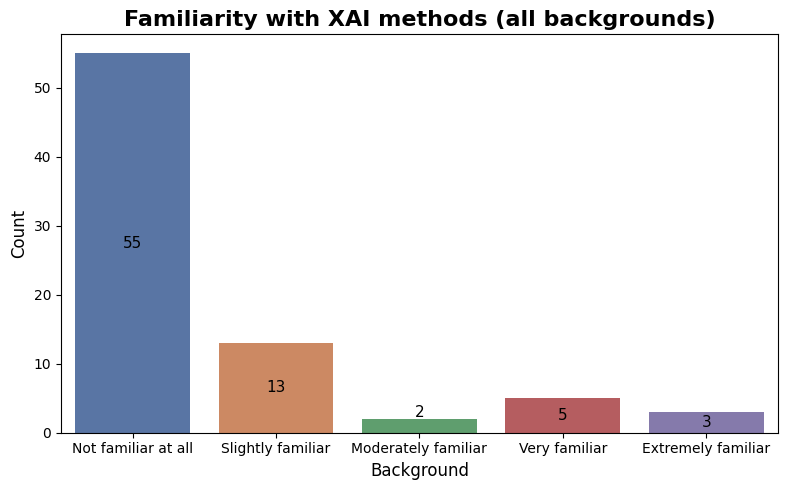

70.5% of responses came from participants with no familiarity with XAI methods, while 16.7% with a slight familiarity.


In [13]:
# Define the order for the categories
order = ['Not familiar at all', 'Slightly familiar', 'Moderately familiar', 'Very familiar', 'Extremely familiar']

# Plot the data
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=responses, x="Q3", palette="deep", hue="Q3", legend=False, order=order, hue_order=hue_order)
plt.title('Familiarity with XAI methods (all backgrounds)', fontsize=16, fontweight='bold')
plt.xlabel('Background', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Add count labels in the middle of bars
for i, container in enumerate(ax.containers):
    # Get the bars heights, widths and positions
    for bar in container:
            height = bar.get_height()
            width = bar.get_width()
            x_pos = bar.get_x()
            if i != 2:
                # Place the counts at the centre of each bar
                ax.text(x_pos + width/2., height/2, f'{int(height)}', ha='center', va='center', fontsize=11)
            else:
                 # Place the count above the bar
                 ax.text(x_pos + width/2., height + 1, f'{int(height)}', ha='center', va='center', fontsize=11)


plt.tight_layout()
plt.show()

print(f"{round(responses[responses['Q3'] == 'Not familiar at all'].shape[0]/len(responses) * 100, 1)}% of responses came from participants with no familiarity with XAI methods, while " \
      f"{round(responses[responses['Q3'] == 'Slightly familiar'].shape[0]/len(responses) * 100, 1)}% with a slight familiarity.")

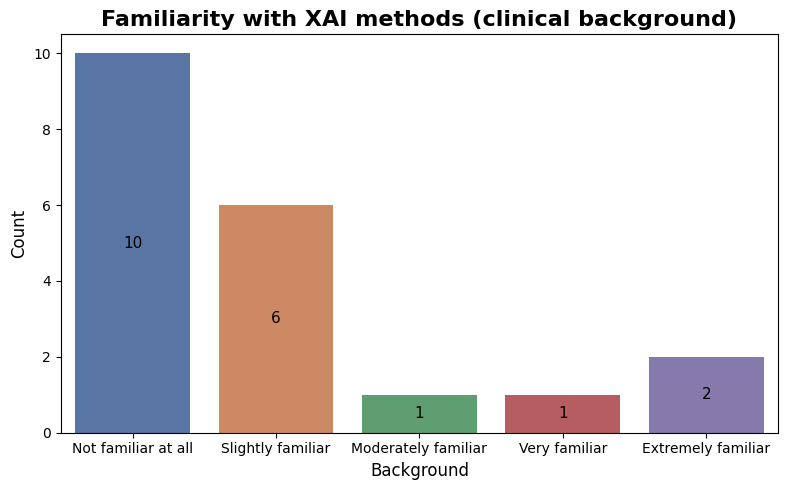

50.0% of responses from participants with clinical background pointed to no familiarity with XAI methods, while 30.0% to slight familiarity.


In [14]:
# Plot the same question but for clinical background
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=responses_clinical, x="Q3", palette="deep", hue="Q3", legend=False, order=order, hue_order=hue_order)
plt.title('Familiarity with XAI methods (clinical background)', fontsize=16, fontweight='bold')
plt.xlabel('Background', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Add count labels in the middle of bars
for container in ax.containers:
    # Get the bars heights, widths and positions
    for bar in container:
        height = bar.get_height()
        width = bar.get_width()
        x_pos = bar.get_x()
        # Place the counts at the centre of each bar
        ax.text(x_pos + width/2., height/2, f'{int(height)}', ha='center', va='center', fontsize=11)

plt.tight_layout()
plt.show()

print(f"{round(responses_clinical[responses_clinical['Q3'] == 'Not familiar at all'].shape[0]/len(responses_clinical) * 100, 1)}% of responses from participants with clinical "\
      f"background pointed to no familiarity with XAI methods, while {round(responses_clinical[responses_clinical['Q3'] == 'Slightly familiar'].shape[0]/len(responses_clinical) * 100, 1)}% to slight familiarity.")

### Analysis

#### Understanding Difficulty

We now analyse responses relating to the ease of understanding of Explanation A in comparison with Explanation B (enhanced with LLM-generated report). 

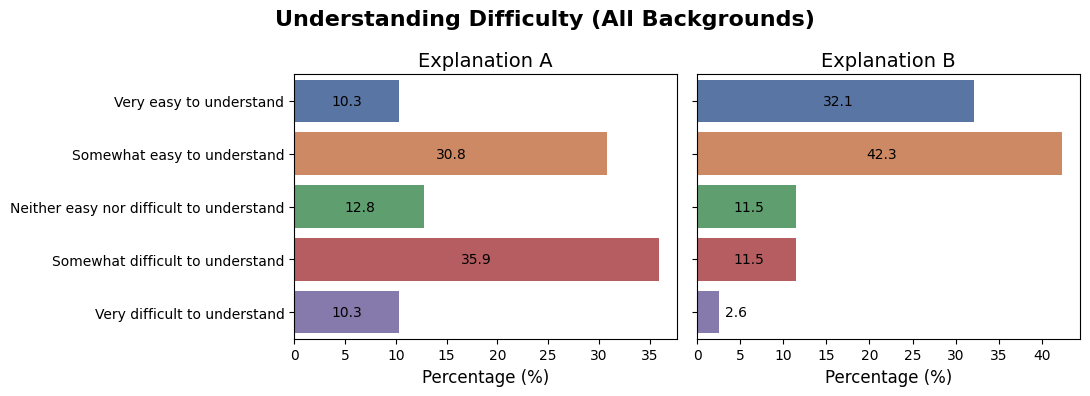

***Counts for the questions (Explanation A and B)***

Q5a
Very easy to understand                      8
Somewhat easy to understand                 24
Neither easy nor difficult to understand    10
Somewhat difficult to understand            28
Very difficult to understand                 8
Name: count, dtype: int64

Q5b
Very easy to understand                     25
Somewhat easy to understand                 33
Neither easy nor difficult to understand     9
Somewhat difficult to understand             9
Very difficult to understand                 2
Name: count, dtype: int64


In [15]:
# Define the order for the categories
order_q5 = ['Very easy to understand', 'Somewhat easy to understand', 'Neither easy nor difficult to understand', 'Somewhat difficult to understand', 'Very difficult to understand']
hue_order_q5 = ['Very easy to understand', 'Somewhat easy to understand', 'Neither easy nor difficult to understand', 'Somewhat difficult to understand', 'Very difficult to understand']

# Calculate percentages (round to 0 dp)
q5a_counts = responses["Q5a"].value_counts()
q5a_percentages = (q5a_counts / len(responses) * 100).round(1).reindex(index=order_q5, fill_value=0)
q5b_counts = responses["Q5b"].value_counts()
q5b_percentages = (q5b_counts / len(responses) * 100).round(1).reindex(index=order_q5, fill_value=0)

# Plot side-by-side answers for Q5a and Q5b (Explanation A and Explanation B) 
fig, axes = plt.subplots(1, 2, figsize=(11, 4))
fig.suptitle('Understanding Difficulty (All Backgrounds)', fontsize=16, fontweight='bold')

sns.barplot(y=q5a_percentages.index, x=q5a_percentages.values, hue=q5a_percentages.index, palette="deep", legend=False, ax=axes[0])
axes[0].set_title('Explanation A', fontsize=14)
axes[0].set_xlabel('Percentage (%)', fontsize=12)
axes[0].set_ylabel('', fontsize=12)

sns.barplot(y=q5b_percentages.index, x=q5b_percentages.values, hue=q5a_percentages.index, palette="deep", legend=False, ax=axes[1])
axes[1].set_title('Explanation B', fontsize=14)
axes[1].set_xlabel('Percentage (%)', fontsize=12)
axes[1].set_ylabel('', fontsize=12)
axes[1].set_yticklabels("")


# Add percentage labels to the bars (with special treatment of small bars)
for i, v in enumerate(q5a_percentages.values):
    axes[0].text(v/2 - 1.5, i, f'{v:.1f}', va='center', fontsize=10)

for i, v in enumerate(q5b_percentages.values):
    if v > 4:
        axes[1].text(v/2 - 1.5, i, f'{v:.1f}', va='center', fontsize=10)
    else:
        axes[1].text(v/2 + 2, i, f'{v:.1f}', va='center', fontsize=10)


plt.tight_layout()
plt.show()

print("***Counts for the questions (Explanation A and B)***\n")
print(q5a_counts.reindex(index=order_q5, fill_value=0))
print()
print(q5b_counts.reindex(index=order_q5, fill_value=0))

In Explanation B (LLM-enhanced) we can observe an increase in 'Very easy to understand', 32.1% (n=25) vs 10.3% (n=8), and 'Somewhat easy to understand', 42.3% (n=33) vs 30.8% (n=24), compared to Explanation A. There is also a marked decrease in 'Somewhat difficult to understand', 11.5% (n=9) vs 35.9% (n=28), and 'Very difficult to understand', 2.6% (n=2) vs 10.3% (n=8). The observable findings support a conclusion that Explanation B, utilising the LLM-generated report, is easier to understand among respondents from all backgrounds.

To perform a statistical test, we assign scores to the ordinal data (categories) in all responses, following this mapping schema:

* 'Very difficult to understand' = 1
* 'Somewhat difficult to understand' = 2
* 'Neither easy nor difficult to understand' = 3
* 'Somewhat easy to understand' = 4
* 'Very easy to understand' = 5

Tested hypothesis: There is a statistical difference between scores for Q5a and Q5b answers from respondents with all backgrounds.

Method: Wilcoxon Signed-Rank Test 

In [16]:
# Define mapping schema for the question (5a and 5b)
mapping = {
        'Very difficult to understand': 1,
        'Somewhat difficult to understand': 2,
        'Neither easy nor difficult to understand': 3,
        'Somewhat easy to understand': 4,
        'Very easy to understand': 5
    }

# Map (score) responses
responses_Q5a_ranked = responses['Q5a'].map(mapping)
responses_Q5b_ranked = responses['Q5b'].map(mapping)

print_statistics(responses_Q5a_ranked, 
                 responses_Q5b_ranked, 
                 "Q5 statistics (all backgrounds):")

***Q5 statistics (all backgrounds):***

Explanation A - Mean Score: 2.95
Explanation B - Mean Score: 3.90
Mean Scores' Difference (Explanation B - Explanation A): 0.95

Wilcoxon signed-rank test results:
Statistic: 231.0
p-value: 8.085518943738803e-07

The difference is statistically significant.


With mean score difference (0.95) and considering the statistical test (*p*-value: 8.09e-07) we can confirm the improvement in understandibility brought by Explanation B is statistically significant.

We now analyse the same responses but for both backgrounds individually.

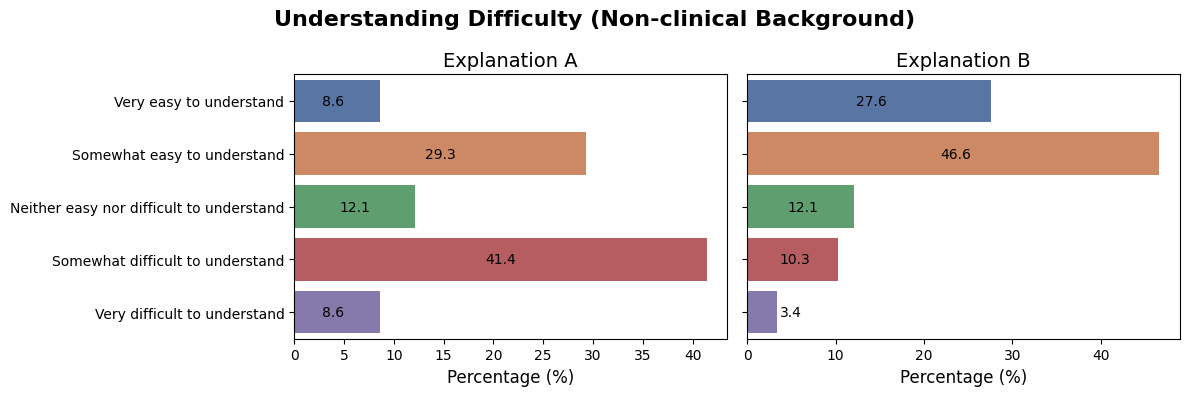

***Counts for the questions (Explanation A and B) - non-clinical***

Q5a
Very easy to understand                      5
Somewhat easy to understand                 17
Neither easy nor difficult to understand     7
Somewhat difficult to understand            24
Very difficult to understand                 5
Name: count, dtype: int64

Q5b
Very easy to understand                     16
Somewhat easy to understand                 27
Neither easy nor difficult to understand     7
Somewhat difficult to understand             6
Very difficult to understand                 2
Name: count, dtype: int64


In [17]:
# Calculate percentages for non-clinical respondents
q5a_noncl_counts = responses_nonclinical["Q5a"].value_counts()
q5a_noncl_percentages = (q5a_noncl_counts / len(responses_nonclinical) * 100).round(1).reindex(index=order_q5, fill_value=0)
q5b_noncl_counts = responses_nonclinical["Q5b"].value_counts()
q5b_noncl_percentages = (q5b_noncl_counts / len(responses_nonclinical) * 100).round(1).reindex(index=order_q5, fill_value=0)

# Calculate percentages for clinical respondents
q5a_clin_counts = responses_clinical["Q5a"].value_counts()
q5a_clin_percentages = (q5a_clin_counts / len(responses_clinical) * 100).round(1).reindex(index=order_q5, fill_value=0)
q5b_clin_counts = responses_clinical["Q5b"].value_counts()
q5b_clin_percentages = (q5b_clin_counts / len(responses_clinical) * 100).round(1).reindex(index=order_q5, fill_value=0)

# Plot side-by-side answers for Q5a and Q5b (Explanation A and Explanation B) 
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Understanding Difficulty (Non-clinical Background)', fontsize=16, fontweight='bold')

sns.barplot(y=q5a_noncl_percentages.index, x=q5a_noncl_percentages.values, hue=q5a_noncl_percentages.index, palette="deep", legend=False, ax=axes[0])
axes[0].set_title('Explanation A', fontsize=14)
axes[0].set_xlabel('Percentage (%)', fontsize=12)
axes[0].set_ylabel('', fontsize=12)

sns.barplot(y=q5b_noncl_percentages.index, x=q5b_noncl_percentages.values, hue=q5b_noncl_percentages.index, palette="deep", legend=False, ax=axes[1])
axes[1].set_title('Explanation B', fontsize=14)
axes[1].set_xlabel('Percentage (%)', fontsize=12)
axes[1].set_ylabel('', fontsize=12)
axes[1].set_yticklabels("")

# Add percentage labels to the bars
for i, v in enumerate(q5a_noncl_percentages.values):
    axes[0].text(v/2 - 1.5, i, f'{v:.1f}', va='center', fontsize=10)

for i, v in enumerate(q5b_noncl_percentages.values):
    if v > 4:
        axes[1].text(v/2 - 1.5, i, f'{v:.1f}', va='center', fontsize=10)
    else:
        axes[1].text(v/2 + 2, i, f'{v:.1f}', va='center', fontsize=10)


plt.tight_layout()
plt.show()


print("***Counts for the questions (Explanation A and B) - non-clinical***\n")
print(q5a_noncl_counts.reindex(index=order_q5, fill_value=0))
print()
print(q5b_noncl_counts.reindex(index=order_q5, fill_value=0))

In [18]:
# Map (score) responses from participants with non-clinical background
responses_nonclin_Q5a_ranked = responses_nonclinical['Q5a'].map(mapping)
responses_nonclin_Q5b_ranked = responses_nonclinical['Q5b'].map(mapping)

print_statistics(responses_nonclin_Q5a_ranked, 
                 responses_nonclin_Q5b_ranked, 
                 "Q5 statistics (non-clinical background):")

***Q5 statistics (non-clinical background):***

Explanation A - Mean Score: 2.88
Explanation B - Mean Score: 3.84
Mean Scores' Difference (Explanation B - Explanation A): 0.97

Wilcoxon signed-rank test results:
Statistic: 129.0
p-value: 7.307927942727765e-06

The difference is statistically significant.


For respondents with non-clinical background, the proportion of catergories seen in Explanation B roughly corresponds to the data for all backgrounds. It can be explained by the large majority of completed surveys comming from the group (57). 

With mean score difference (0.97) and considering the statistical test (*p*-value: 7.30e-06) we can confirm the improvement in understandibility brought by Explanation B is statistically significant in the non-clinical respondents group.

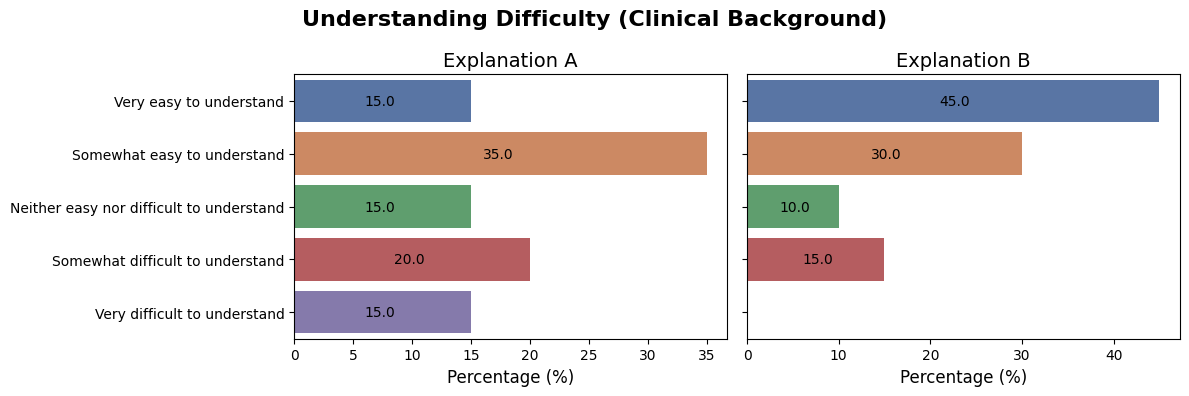

***Counts for the questions (Explanation A and B) - clinical background***

Q5a
Very easy to understand                     3
Somewhat easy to understand                 7
Neither easy nor difficult to understand    3
Somewhat difficult to understand            4
Very difficult to understand                3
Name: count, dtype: int64

Q5b
Very easy to understand                     9
Somewhat easy to understand                 6
Neither easy nor difficult to understand    2
Somewhat difficult to understand            3
Very difficult to understand                0
Name: count, dtype: int64


In [19]:
# Plot side-by-side answers for Q5a and Q5b (Explanation A and Explanation B) 
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Understanding Difficulty (Clinical Background)', fontsize=16, fontweight='bold')

sns.barplot(y=q5a_clin_percentages.index, x=q5a_clin_percentages.values, hue=q5a_clin_percentages.index, palette="deep", legend=False, ax=axes[0])
axes[0].set_title('Explanation A', fontsize=14)
axes[0].set_xlabel('Percentage (%)', fontsize=12)
axes[0].set_ylabel('', fontsize=12)

sns.barplot(y=q5b_clin_percentages.index, x=q5b_clin_percentages.values, hue=q5b_clin_percentages.index, palette="deep", legend=False, ax=axes[1])
axes[1].set_title('Explanation B', fontsize=14)
axes[1].set_xlabel('Percentage (%)', fontsize=12)
axes[1].set_ylabel('', fontsize=12)
axes[1].set_yticklabels("")

# Add percentage labels to the bars
for i, v in enumerate(q5a_clin_percentages.values):
    axes[0].text(v/2 - 1.5, i, f'{v:.1f}', va='center', fontsize=10)

for i, v in enumerate(q5b_clin_percentages.values):
    if v == 0:
        continue
    elif v > 4:
        axes[1].text(v/2 - 1.5, i, f'{v:.1f}', va='center', fontsize=10)
    else:
        axes[1].text(v/2 + 2, i, f'{v:.1f}', va='center', fontsize=10)


plt.tight_layout()
plt.show()

print("***Counts for the questions (Explanation A and B) - clinical background***\n")
print(q5a_clin_counts.reindex(index=order_q5, fill_value=0))
print()
print(q5b_clin_counts.reindex(index=order_q5, fill_value=0))

In [20]:
# Map (score) responses from participants with non-clinical background
responses_clin_Q5a_ranked = responses_clinical['Q5a'].map(mapping)
responses_clin_Q5b_ranked = responses_clinical['Q5b'].map(mapping)

# Obtain statistics
print_statistics(responses_clin_Q5a_ranked, 
                 responses_clin_Q5b_ranked, 
                 "Q5 statistics (clinical background):")

***Q5 statistics (clinical background):***

Explanation A - Mean Score: 3.15
Explanation B - Mean Score: 4.05
Mean Scores' Difference (Explanation B - Explanation A): 0.90

Wilcoxon signed-rank test results:
Statistic: 16.0
p-value: 0.03563030369968798

The difference is statistically significant.


When analysing data for respondents with a clinical background specifically, in Explanation B (LLM-enhanced) we can observe an increase in 'Very easy to understand', 45% (n=9) vs 15% (n=3), and the largest decrease in 'Very difficult to understand', 15% (n=3) vs 0%, compared to Explanation A. It is worth mentioning, that Explanation A, this group of respondents had a larger share of answers across the two most polarised categories than the non-clinical group. 

The change in scores for answers (0.90) is statistically significant (*p*-value: ~0.0356).

For the ease of interpretation, we visualise the scale and direction of change in answers across both explanations in two separate groups: respondents with non-clinical and clinical backgrounds. 

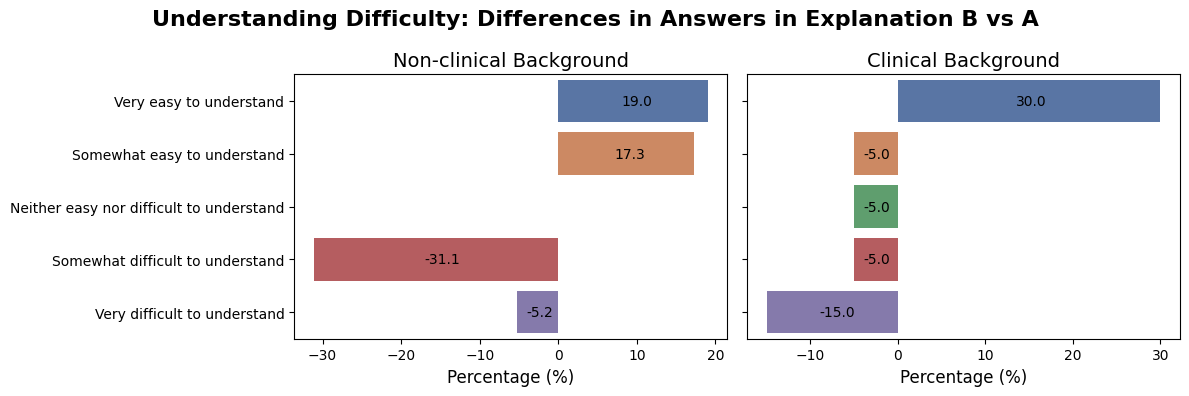

In [21]:
# Calculate the difference in percentages for non-clinical respondents
q5b_noncl_difference = q5b_noncl_percentages - q5a_noncl_percentages

# Calculate the difference in percentages for clinical respondents
q5b_clin_difference = q5b_clin_percentages - q5a_clin_percentages

# Plot side-by-side the differences in answers for both groups 
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Understanding Difficulty: Differences in Answers in Explanation B vs A', fontsize=16, fontweight='bold')

sns.barplot(y=q5b_noncl_difference.index, x=q5b_noncl_difference.values, hue=q5b_noncl_difference.index, palette="deep", legend=False, ax=axes[0])
axes[0].set_title('Non-clinical Background', fontsize=14)
axes[0].set_xlabel('Percentage (%)', fontsize=12)
axes[0].set_ylabel('', fontsize=12)

sns.barplot(y=q5b_clin_difference.index, x=q5b_clin_difference.values, hue=q5b_clin_difference.index, palette="deep", legend=False, ax=axes[1])
axes[1].set_title('Clinical Background', fontsize=14)
axes[1].set_xlabel('Percentage (%)', fontsize=12)
axes[1].set_ylabel('', fontsize=12)
axes[1].set_yticklabels("")

# Add percentage labels to the bars
for i, v in enumerate(q5b_noncl_difference.values):
    if v == 0:
        continue
    else:
        axes[0].text(v/2 - 1.5, i, f'{v:.1f}', va='center', fontsize=10)

for i, v in enumerate(q5b_clin_difference.values):
        axes[1].text(v/2 - 1.5, i, f'{v:.1f}', va='center', fontsize=10)
    
plt.tight_layout()
plt.show()

In respondents with a clinical background we can observe a larger increase for 'Very easy to understand', 30.0% (n=6) vs 19.0% (n=11) in non-clinical background. For respondents with non-clinical backgrounds, there was a larger decrease in 'Somewhat difficult to understand', 31.1 percentage points (n=18), which likely corresponds to increases in the 'easy to understand' categories, particularly the 17.3 percentage point (n=10) increase in 'Somewhat easy to understand.'

The observed changes in the first two categories of answers could lead to a conclusion that Explanation B was particularly easier for respondents with clinical backgrounds; however, the relatively small number of completed surveys for that group warrants caution and requires further research with a larger number of samples.

**Understanding Difficulty (Lower familiarity with AI/XAI)**

Now we look at the differences between the level of understanding for Explanation A and B; however, we only include responses coming from the survey participants with less familiarity with AI and XAI methods. 

For the purpose of this research, a respondent is considered to have less familiarity with AI/XAI methods if they selected one of the answers for both Q2 and Q3:
* 'Not familiar at all'
* 'Slightly familiar'
* 'Moderately familiar'


In [22]:
# Filter responses from respondents with less familiarity with AI and XAI
categories_less_familiar = ['Not familiar at all', 'Slightly familiar', 'Moderately familiar']
responses_less_familiar = responses[(responses['Q2'].isin(categories_less_familiar)) & (responses['Q3'].isin(categories_less_familiar))]

# Filter based on participant background
responses_less_familiar_clinical = responses_less_familiar[responses_less_familiar['Q1'] == "Clinical"]
responses_less_familiar_nonclinical = responses_less_familiar[responses_less_familiar['Q1'] == "Non-clinical"]

print("***Respondents less familiar with AI/XAI methods (count)***\n")
print(f"Clinical background: {responses_less_familiar_clinical.shape[0]}\n" \
      f"Non-clinical background: {responses_less_familiar_nonclinical.shape[0]}")

***Respondents less familiar with AI/XAI methods (count)***

Clinical background: 17
Non-clinical background: 47


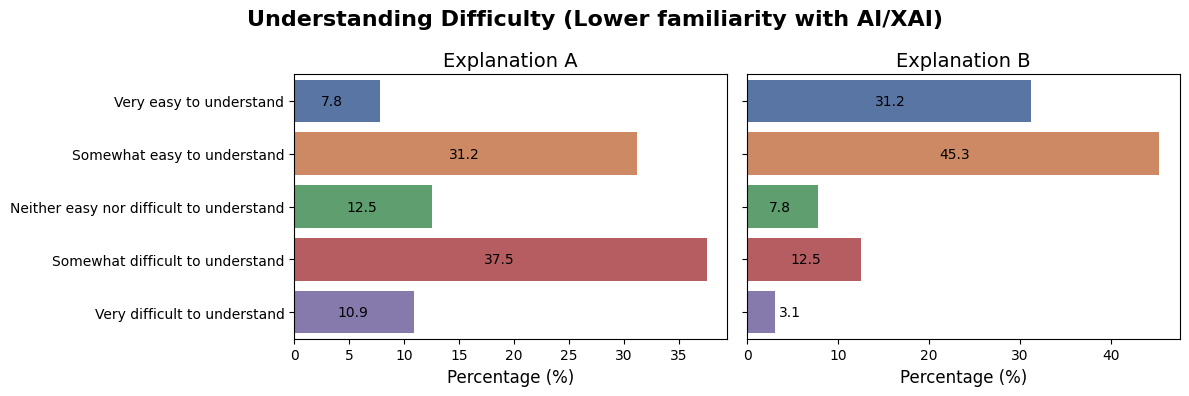

***Counts for the questions (Explanation A and B) - less familiar with AI/XAI methods***

Q5a
Very easy to understand                      5
Somewhat easy to understand                 20
Neither easy nor difficult to understand     8
Somewhat difficult to understand            24
Very difficult to understand                 7
Name: count, dtype: int64

Q5b
Very easy to understand                     20
Somewhat easy to understand                 29
Neither easy nor difficult to understand     5
Somewhat difficult to understand             8
Very difficult to understand                 2
Name: count, dtype: int64


In [23]:
# Calculate percentages for respondents who are less familiar with AI/XAI
q5a_lf_counts = responses_less_familiar["Q5a"].value_counts()
q5a_lf_percentages = (q5a_lf_counts / len(responses_less_familiar) * 100).round(1).reindex(index=order_q5, fill_value=0)
q5b_lf_counts = responses_less_familiar["Q5b"].value_counts()
q5b_lf_percentages = (q5b_lf_counts / len(responses_less_familiar) * 100).round(1).reindex(index=order_q5, fill_value=0)

# Plot side-by-side answers for Q5a and Q5b (Explanation A and Explanation B) 
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Understanding Difficulty (Lower familiarity with AI/XAI)', fontsize=16, fontweight='bold')

sns.barplot(y=q5a_lf_percentages.index, x=q5a_lf_percentages.values, hue=q5a_lf_percentages.index, palette="deep", legend=False, ax=axes[0])
axes[0].set_title('Explanation A', fontsize=14)
axes[0].set_xlabel('Percentage (%)', fontsize=12)
axes[0].set_ylabel('', fontsize=12)

sns.barplot(y=q5b_lf_percentages.index, x=q5b_lf_percentages.values, hue=q5b_lf_percentages.index, palette="deep", legend=False, ax=axes[1])
axes[1].set_title('Explanation B', fontsize=14)
axes[1].set_xlabel('Percentage (%)', fontsize=12)
axes[1].set_ylabel('', fontsize=12)
axes[1].set_yticklabels("")

# Add percentage labels to the bars
for i, v in enumerate(q5a_lf_percentages.values):
    axes[0].text(v/2 - 1.5, i, f'{v:.1f}', va='center', fontsize=10)

for i, v in enumerate(q5b_lf_percentages.values):
    if v > 4:
        axes[1].text(v/2 - 1.5, i, f'{v:.1f}', va='center', fontsize=10)
    else:
        axes[1].text(v/2 + 2, i, f'{v:.1f}', va='center', fontsize=10)


plt.tight_layout()
plt.show()

print("***Counts for the questions (Explanation A and B) - less familiar with AI/XAI methods***\n")
print(q5a_lf_counts.reindex(index=order_q5, fill_value=0))
print()
print(q5b_lf_counts.reindex(index=order_q5, fill_value=0))

In [24]:
# Map (score) responses from participants with lower familiarity with AI/XAI
responses_lf_Q5a_ranked = responses_less_familiar['Q5a'].map(mapping)
responses_lf_Q5b_ranked = responses_less_familiar['Q5b'].map(mapping)

print_statistics(responses_lf_Q5a_ranked, 
                 responses_lf_Q5b_ranked, 
                 "Q5 statistics (lower familiarity with AI/XAI, all backgrounds):")

***Q5 statistics (lower familiarity with AI/XAI, all backgrounds):***

Explanation A - Mean Score: 2.88
Explanation B - Mean Score: 3.89
Mean Scores' Difference (Explanation B - Explanation A): 1.02

Wilcoxon signed-rank test results:
Statistic: 113.0
p-value: 1.1196675081140402e-06

The difference is statistically significant.


In Explanation B (LLM-enhanced) we can observe an increase in 'Very easy to understand', 31.2% (n=20) vs 7.8% (n=5), and 'Somewhat easy to understand', 45.3% (n=29) vs 31.2% (n=20), compared to Explanation A. There is also a marked decrease in 'Somewhat difficult to understand', 12.5% (n=8) vs 37.5% (n=24), and 'Very difficult to understand', 3.1% (n=2) vs 10.9% (n=7). 

A trend observed in visualisation above is further confirmed by the statistical test (*p*-value: 1.11e-6). With mean score difference of 1.02, Explanation B significantly improves understanding of AI-made predictions for respondents from all backgrounds who have less experience in AI/XAI methods.

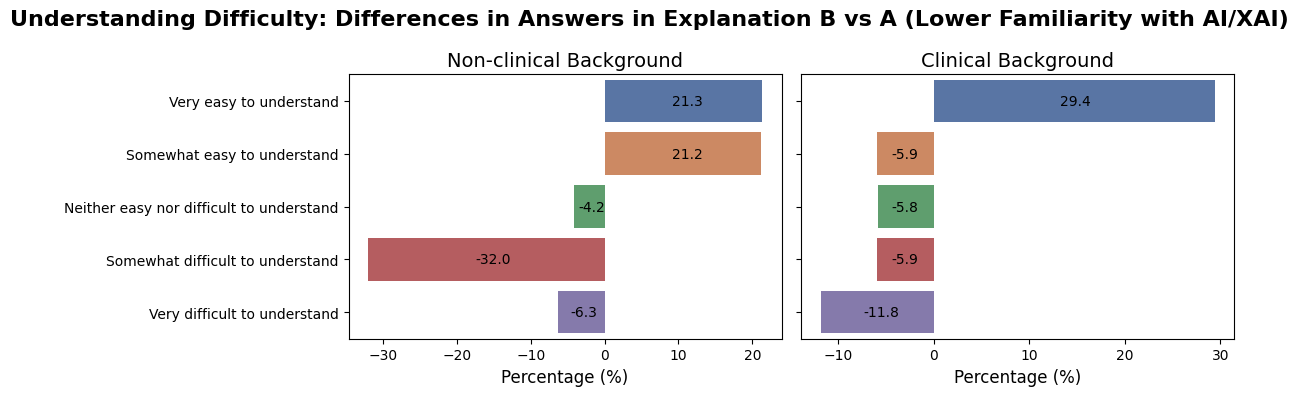

***Counts for the questions (Explanation A and B) - less familiarity with AI/XAI, non-clinical***

Q5a
Very easy to understand                      4
Somewhat easy to understand                 13
Neither easy nor difficult to understand     5
Somewhat difficult to understand            20
Very difficult to understand                 5
Name: count, dtype: int64

Q5b
Very easy to understand                     14
Somewhat easy to understand                 23
Neither easy nor difficult to understand     3
Somewhat difficult to understand             5
Very difficult to understand                 2
Name: count, dtype: int64
----------

***Counts for the questions (Explanation A and B) - less familiarity with AI/XAI, clinical***

Q5a
Very easy to understand                     1
Somewhat easy to understand                 7
Neither easy nor difficult to understand    3
Somewhat difficult to understand            4
Very difficult to understand                2
Name: count, dtype: int64

Q5

In [25]:
# Calculate percentages for non-clinical respondents
q5a_lf_noncl_counts = responses_less_familiar_nonclinical["Q5a"].value_counts()
q5a_lf_noncl_percentages = (q5a_lf_noncl_counts / len(responses_less_familiar_nonclinical) * 100).round(1).reindex(index=order_q5, fill_value=0)
q5b_lf_noncl_counts = responses_less_familiar_nonclinical["Q5b"].value_counts()
q5b_lf_noncl_percentages = (q5b_lf_noncl_counts / len(responses_less_familiar_nonclinical) * 100).round(1).reindex(index=order_q5, fill_value=0)

# Calculate the difference in percentages for non-clinical respondents
q5b_lf_noncl_difference = q5b_lf_noncl_percentages - q5a_lf_noncl_percentages

# Calculate percentages for clinical respondents
q5a_lf_clin_counts = responses_less_familiar_clinical["Q5a"].value_counts()
q5a_lf_clin_percentages = (q5a_lf_clin_counts / len(responses_less_familiar_clinical) * 100).round(1).reindex(index=order_q5, fill_value=0)
q5b_lf_clin_counts = responses_less_familiar_clinical["Q5b"].value_counts()
q5b_lf_clin_percentages = (q5b_lf_clin_counts / len(responses_less_familiar_clinical) * 100).round(1).reindex(index=order_q5, fill_value=0)

# Calculate the difference in percentages for clinical respondents
q5b_lf_clin_difference = q5b_lf_clin_percentages - q5a_lf_clin_percentages

# Plot side-by-side the differences in answers for both groups
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Understanding Difficulty: Differences in Answers in Explanation B vs A (Lower Familiarity with AI/XAI)', fontsize=16, fontweight='bold')

sns.barplot(y=q5b_lf_noncl_difference.index, x=q5b_lf_noncl_difference.values, hue=q5b_lf_noncl_difference.index, palette="deep", legend=False, ax=axes[0])
axes[0].set_title('Non-clinical Background', fontsize=14)
axes[0].set_xlabel('Percentage (%)', fontsize=12)
axes[0].set_ylabel('', fontsize=12)

sns.barplot(y=q5b_lf_clin_difference.index, x=q5b_lf_clin_difference.values, hue=q5b_lf_clin_difference.index, palette="deep", legend=False, ax=axes[1])
axes[1].set_title('Clinical Background', fontsize=14)
axes[1].set_xlabel('Percentage (%)', fontsize=12)
axes[1].set_ylabel('', fontsize=12)
axes[1].set_yticklabels("")

# Add percentage labels to the bars
for i, v in enumerate(q5b_lf_noncl_difference.values):
    axes[0].text(v/2 - 1.5, i, f'{v:.1f}', va='center', fontsize=10)

for i, v in enumerate(q5b_lf_clin_difference.values):
    axes[1].text(v/2 - 1.5 , i, f'{v:.1f}', va='center', fontsize=10)


plt.tight_layout()
plt.show()

print("***Counts for the questions (Explanation A and B) - less familiarity with AI/XAI, non-clinical***\n")
print(q5a_lf_noncl_counts.reindex(index=order_q5, fill_value=0))
print()
print(q5b_lf_noncl_counts.reindex(index=order_q5, fill_value=0))
print("-" * 10)
print("\n***Counts for the questions (Explanation A and B) - less familiarity with AI/XAI, clinical***\n")
print(q5a_lf_clin_counts.reindex(index=order_q5, fill_value=0))
print()
print(q5b_lf_clin_counts.reindex(index=order_q5, fill_value=0))

In respondents with a clinical background we can observe a relatively larger increase for 'Very easy to understand', 29.4% (n=5) vs 21.3% (n=10) in non-clinical background. For respondents with non-clinical backgrounds, there was a larger decrease in 'Somewhat difficult to understand', 32.0 percentage points (n=15), which likely corresponds to increases in the 'easy to understand' categories, i.e. the 21.2 percentage point (n=10) increase in 'Somewhat easy to understand and 21.3 percentage point (n=10) in 'Very easy to understand'.

The observed changes in the first two categories of answers could lead to a conclusion that Explanation B was particularly easier for respondents with clinical backgrounds; however, the relatively small number of completed surveys for that group warrants caution and requires further research with a larger number of samples. 

**Understanding Difficulty Across Different Samples (Lower familiarity with AI/XAI)**

In [26]:
# Filter subsets for specific samples
borderline_sample = responses_less_familiar[responses_less_familiar["sample_type"] == "borderline"]
benign_sample = responses_less_familiar[responses_less_familiar["sample_type"] == "benign"]
malignant_sample = responses_less_familiar[responses_less_familiar["sample_type"] == "malignant"]

samples = [borderline_sample, benign_sample, malignant_sample]
sample_names = ["borderline_sample", "benign_sample", "malignant_sample"]

# print statistics for all samples
for sample, name in zip(samples, sample_names):
    print_statistics(sample['Q5a'].map(mapping),
                     sample['Q5b'].map(mapping),
                    f"Q5 statistics ({name})")
    print("-" * 30)
    print()


***Q5 statistics (borderline_sample)***

Explanation A - Mean Score: 3.24
Explanation B - Mean Score: 4.10
Mean Scores' Difference (Explanation B - Explanation A): 0.86

Wilcoxon signed-rank test results:
Statistic: 5.0
p-value: 0.002054718976131808

The difference is statistically significant.
------------------------------

***Q5 statistics (benign_sample)***

Explanation A - Mean Score: 2.84
Explanation B - Mean Score: 3.56
Mean Scores' Difference (Explanation B - Explanation A): 0.72

Wilcoxon signed-rank test results:
Statistic: 24.0
p-value: 0.010691074702570167

The difference is statistically significant.
------------------------------

***Q5 statistics (malignant_sample)***

Explanation A - Mean Score: 2.50
Explanation B - Mean Score: 4.11
Mean Scores' Difference (Explanation B - Explanation A): 1.61

Wilcoxon signed-rank test results:
Statistic: 11.0
p-value: 0.0029505294543981766

The difference is statistically significant.
------------------------------



The improvement in Explanation B (LLM-enhanced) is significant across all samples; however, the largest mean score difference, 1.61, is observed for the sample with 'Malignant' prediction, going up from 2.50 (Explanation A) to 4.11 (Explanation B), with $p$-value of ~0.00295. While the greatest benefit of Explanation B is observed in a scenario where AI system predicted a high risk of malignancy, it is important to remember that there was the lowest number of responses collected for this specific sample (19).

#### Trust and Actionability

Next, we look at the additional two questions we had asked respondents with clinical background only:

* Trust: Does Explanation A make you feel more confident about the AI's borderline prediction?
* Actionability: If you were to make a clinical decision, would you consider Explanation A for this borderline prediction to be helpful?

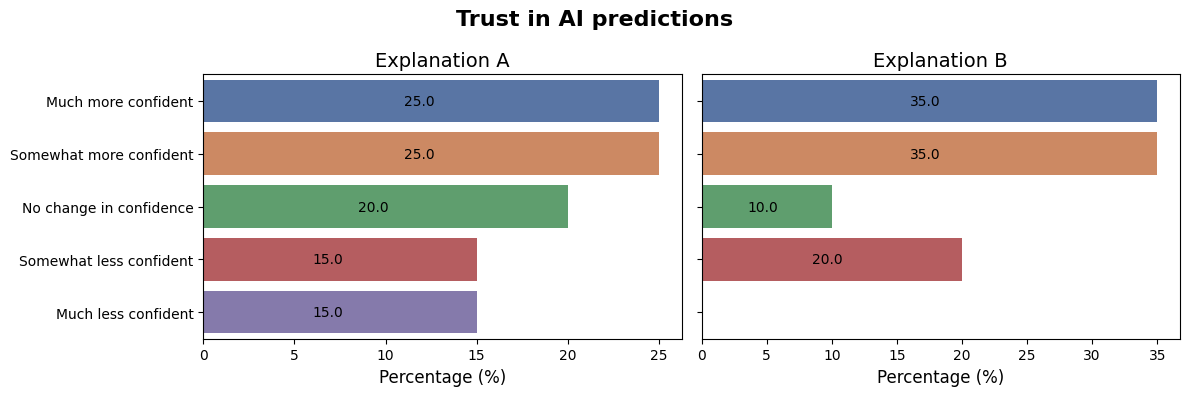

***Counts for the questions (Explanation A and B) - clinical background only***

Q6a
Much more confident        5
Somewhat more confident    5
No change in confidence    4
Somewhat less confident    3
Much less confident        3
Name: count, dtype: int64

Q6b
Much more confident        7
Somewhat more confident    7
No change in confidence    2
Somewhat less confident    4
Much less confident        0
Name: count, dtype: int64


In [27]:
# Define categories order for Q6 and Q7
q6_order = ['Much more confident', 'Somewhat more confident', 'No change in confidence', 'Somewhat less confident', 'Much less confident']
q7_order = ['Very helpful - I would rely on this explanation', 'Helpful - I would consider this explanation', 'Somewhat helpful - I would note this explanation', 
            'Not very helpful - I would largely ignore this explanation', 'Not helpful at all - I would disregard this explanation']

# Calculate percentages for non-clinical respondents
q6a_counts = responses_clinical["Q6a"].value_counts()
q6a_percentages = (q6a_counts / len(responses_clinical) * 100).round(1).reindex(index=q6_order, fill_value=0)
q6b_counts = responses_clinical["Q6b"].value_counts()
q6b_percentages = (q6b_counts / len(responses_clinical) * 100).round(1).reindex(index=q6_order, fill_value=0)

# Calculate percentages for clinical respondents
q7a_counts = responses_clinical["Q7a"].value_counts()
q7a_percentages = (q7a_counts / len(responses_clinical) * 100).round(1).reindex(index=q7_order, fill_value=0)
q7b_counts = responses_clinical["Q7b"].value_counts()
q7b_percentages = (q7b_counts / len(responses_clinical) * 100).round(1).reindex(index=q7_order, fill_value=0)

# Plot side-by-side answers for Q6a and Q6b (Explanation A and Explanation B) 
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Trust in AI predictions', fontsize=16, fontweight='bold')

sns.barplot(y=q6a_percentages.index, x=q6a_percentages.values, hue=q6a_percentages.index, palette="deep", legend=False, ax=axes[0])
axes[0].set_title('Explanation A', fontsize=14)
axes[0].set_xlabel('Percentage (%)', fontsize=12)
axes[0].set_ylabel('', fontsize=12)

sns.barplot(y=q6b_percentages.index, x=q6b_percentages.values, hue=q6b_percentages.index, palette="deep", legend=False, ax=axes[1])
axes[1].set_title('Explanation B', fontsize=14)
axes[1].set_xlabel('Percentage (%)', fontsize=12)
axes[1].set_ylabel('', fontsize=12)
axes[1].set_yticklabels("")

# Add percentage labels to the bars
for i, v in enumerate(q6a_percentages.values):
    axes[0].text(v/2 - 1.5, i, f'{v:.1f}', va='center', fontsize=10)

for i, v in enumerate(q6b_percentages.values):
    if v == 0:
        continue
    else:
        axes[1].text(v/2 - 1.5 , i, f'{v:.1f}', va='center', fontsize=10)


plt.tight_layout()
plt.show()

print("***Counts for the questions (Explanation A and B) - clinical background only***\n")
print(q6a_counts.reindex(index=q6_order, fill_value=0))
print()
print(q6b_counts.reindex(index=q6_order, fill_value=0))

In [28]:
# Define mapping schema for the question (6a and 6b)
mapping = {
        'Much more confident': 5,
        'Somewhat more confident': 4,
        'No change in confidence': 3,
        'Somewhat less confident': 2,
        'Much less confident': 1
    }

# Map (score) responses from participants with lower familiarity with AI/XAI
responses_Q6a_ranked = responses_clinical["Q6a"].map(mapping)
responses_Q6b_ranked = responses_clinical["Q6b"].map(mapping)

print_statistics(responses_Q6a_ranked, 
                 responses_Q6b_ranked, 
                 "Q6: Trust - statistics (clinical background only):")

***Q6: Trust - statistics (clinical background only):***

Explanation A - Mean Score: 3.30
Explanation B - Mean Score: 3.85
Mean Scores' Difference (Explanation B - Explanation A): 0.55

Wilcoxon signed-rank test results:
Statistic: 28.0
p-value: 0.11686942236065116

The difference is not statistically significant.


Despite of two additional respondents selecting 'Much more confident' and 'Somewhat more confident' for Explanation B, in addition to none of respondents selecting the 'Much less confident' answer for the explanation, the mean score difference (0.55) and statistical test ($p$-value~0.11687) indicate this observable improvement should be treated with caution. Further research with a larger number of collected responses is necessary to evaluate the 'trust' factor of our proposed solution. 

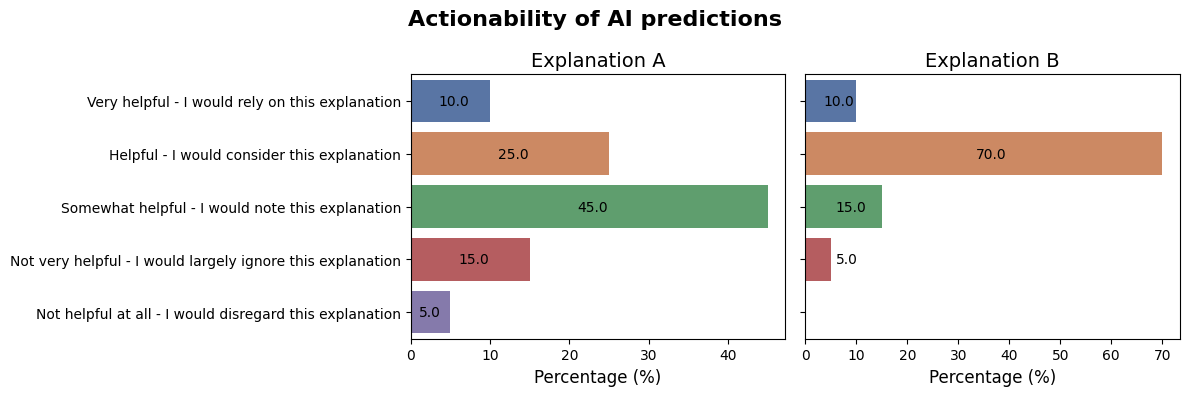

***Counts for the questions (Explanation A and B) - clinical background only***

Q7a
Very helpful - I would rely on this explanation               2
Helpful - I would consider this explanation                   5
Somewhat helpful - I would note this explanation              9
Not very helpful - I would largely ignore this explanation    3
Not helpful at all - I would disregard this explanation       1
Name: count, dtype: int64

Q7b
Very helpful - I would rely on this explanation                2
Helpful - I would consider this explanation                   14
Somewhat helpful - I would note this explanation               3
Not very helpful - I would largely ignore this explanation     1
Not helpful at all - I would disregard this explanation        0
Name: count, dtype: int64


In [29]:
# Plot side-by-side answers for Q7a and Q7b (Explanation A and Explanation B) 
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Actionability of AI predictions', fontsize=16, fontweight='bold')

sns.barplot(y=q7a_percentages.index, x=q7a_percentages.values, hue=q7a_percentages.index, palette="deep", legend=False, ax=axes[0])
axes[0].set_title('Explanation A', fontsize=14)
axes[0].set_xlabel('Percentage (%)', fontsize=12)
axes[0].set_ylabel('', fontsize=12)

sns.barplot(y=q7b_percentages.index, x=q7b_percentages.values, hue=q7b_percentages.index, palette="deep", legend=False, ax=axes[1])
axes[1].set_title('Explanation B', fontsize=14)
axes[1].set_xlabel('Percentage (%)', fontsize=12)
axes[1].set_ylabel('', fontsize=12)
axes[1].set_yticklabels("")

# Add percentage labels to the bars
for i, v in enumerate(q7a_percentages.values):
    axes[0].text(v/2 - 1.5, i, f'{v:.1f}', va='center', fontsize=10)

for i, v in enumerate(q7b_percentages.values):
    if v == 0:
        continue
    elif v > 5:
        axes[1].text(v/2 - 1.5, i, f'{v:.1f}', va='center', fontsize=10)
    else:
        axes[1].text(v/2 + 3.5, i, f'{v:.1f}', va='center', fontsize=10)


plt.tight_layout()
plt.show()

print("***Counts for the questions (Explanation A and B) - clinical background only***\n")
print(q7a_counts.reindex(index=q7_order, fill_value=0))
print()
print(q7b_counts.reindex(index=q7_order, fill_value=0))

In [30]:
# Define mapping schema for the question (7a and 7b)
mapping = {
        'Very helpful - I would rely on this explanation': 5,
        'Helpful - I would consider this explanation': 4,
        'Somewhat helpful - I would note this explanation': 3,
        'Not very helpful - I would largely ignore this explanation': 2,
        'Not helpful at all - I would disregard this explanation': 1
    }

# Map (score) responses from participants with lower familiarity with AI/XAI
responses_Q7a_ranked = responses_clinical["Q7a"].map(mapping)
responses_Q7b_ranked = responses_clinical["Q7b"].map(mapping)

print_statistics(responses_Q7a_ranked, 
                 responses_Q7b_ranked, 
                 "Q7: Actionability - statistics (clinical background only):")

***Q7: Actionability - statistics (clinical background only):***

Explanation A - Mean Score: 3.20
Explanation B - Mean Score: 3.85
Mean Scores' Difference (Explanation B - Explanation A): 0.65

Wilcoxon signed-rank test results:
Statistic: 4.5
p-value: 0.00810688677465752

The difference is statistically significant.


When analysing responses referring to actionability of the proposed solution, we can observe a relatively large increase, 75% (n=14) vs 25% (n=5), for 'Helpful - I would consider this explanation' answer, with 3 less repondents selecting the two answers pointing to a low utility of the Explanation B vs Explanation A.

The mean score difference (0.65) and statistical test ($p$-value~0.0081) indicate that the observable improvement in actionability that comes with LLM-enhanced explanation is statistically significant.

### Conclusions

This analysis supports the conclusion that our proposed tool increases understanding of AI-generated predictions amongst survey respondents. The benefit was observed both in the combined response pool and when examining users with clinical and non-clinical backgrounds separately. The increased understanding was particularly pronounced amongst users less familiar with AI/XAI methods (mean score difference 1.02 vs 0.95 across all respondents). Clinical users expressed a preference for our solution when evaluating its actionability, whilst the trust factor requires further validation with a larger sample.